# Data analysis for heuristics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

In [2]:
from libraries.helpers.load_data import load_courses, load_students
from libraries.algorithms.random import Random
%matplotlib notebook

In [3]:
# load data
courses = load_courses(path="./")
students_dict = load_students(courses, path="./")

## Number of students per course

<IPython.core.display.Javascript object>


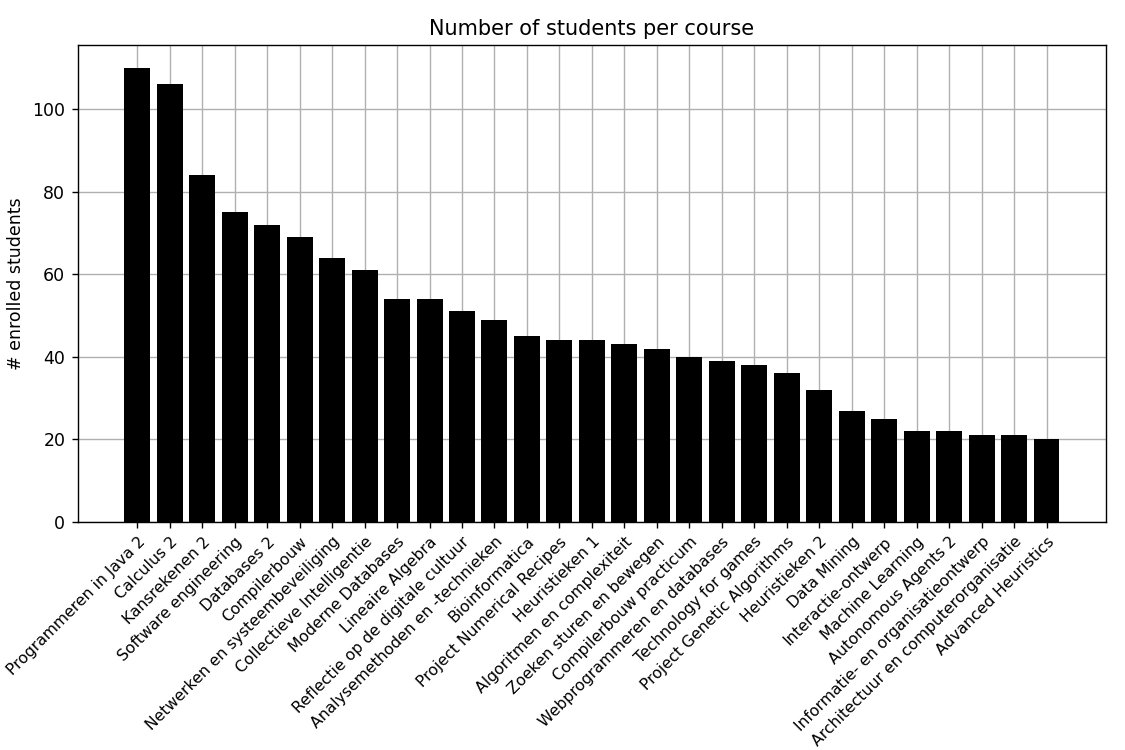

In [4]:
course_names = [course.name for course in courses.values()]
nr_students = [len(course.students) for course in courses.values()]

# courses sorted by nr. of students enrolled
course_df = pd.DataFrame({"course":course_names,"nr. of students":nr_students})
course_df = course_df.sort_values(by=['nr. of students'], ascending=False)

# bar plot of nr. of students per course
plt.figure(figsize=(9, 6), layout='tight')
plt.grid(zorder=0)
plt.bar(course_df['course'], height=course_df['nr. of students'], color='black', zorder=3)
plt.xticks(fontsize=9, rotation=45, rotation_mode='anchor', ha='right')
plt.ylabel('# enrolled students')
plt.title("Number of students per course")
plt.show()
# plt.savefig('./images/student_distribution_across_courses.png', bbox_inches='tight')


## Course pairs that do not share any students

In [5]:
# dict with key=course_name, value=studenten
courses_students = {}
for course in courses.values():
    courses_students[course.name] = set(course.students.keys())

# dict with key=course values= overlapping courses
courses_overlap = {name: [] for name in course_names}

# compare students of course i to courses i+1 tm N
for i in range(len(course_names)):
    for j in np.arange(i+1, len(courses), 1):

        # overlapping students
        overlap = courses_students[course_names[i]] & courses_students[course_names[j]]

        if overlap == set():
#             print(f'NO OVERLAP: {course_names[i]} & {course_names[j]}')
            pass
        else:
            courses_overlap[course_names[i]].append(course_names[j])
            courses_overlap[course_names[j]].append(course_names[i])
#             print(f'OVERLAP of {len(overlap)} -> {course_names[i]} & {course_names[j]}')

# create dataframe showing courses that are compatible
df = pd.DataFrame(index=courses.keys(), columns=courses.keys())

for course1 in courses:
    for course2 in courses:
        if course1 in courses_overlap[course2] or course1 == course2:
            df.loc[course1, course2] = '-'
        else:
            df.loc[course1, course2] = '✓'

# function to change the text color
def color_text(value):
    color = 'green' if value == '✓' else 'red'
    return f'color: {color}'

# apply the color function to the df using applymap
styled_df = df.style.applymap(color_text)

# rotate the column labels to make table less wide
styled_df.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th.col_heading', 'props': [("writing-mode", "vertical-rl"),('height', '140px')]}
])

display(styled_df)

,Advanced Heuristics,Algoritmen en complexiteit,Analysemethoden en -technieken,Architectuur en computerorganisatie,Autonomous Agents 2,Bioinformatica,Calculus 2,Collectieve Intelligentie,Compilerbouw,Compilerbouw practicum,Data Mining,Databases 2,Heuristieken 1,Heuristieken 2,Informatie- en organisatieontwerp,Interactie-ontwerp,Kansrekenen 2,Lineaire Algebra,Machine Learning,Moderne Databases,Netwerken en systeembeveiliging,Programmeren in Java 2,Project Genetic Algorithms,Project Numerical Recipes,Reflectie op de digitale cultuur,Software engineering,Technology for games,Webprogrammeren en databases,Zoeken sturen en bewegen
Advanced Heuristics,-,-,-,-,✓,-,-,-,-,-,✓,-,-,-,✓,-,-,✓,✓,-,-,-,-,-,-,✓,-,-,-
Algoritmen en complexiteit,-,-,✓,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Analysemethoden en -technieken,-,✓,-,-,-,-,-,-,-,-,-,-,-,-,-,✓,-,-,-,-,-,-,-,-,-,-,-,-,-
Architectuur en computerorganisatie,-,-,-,-,✓,✓,-,-,-,-,✓,-,-,-,-,✓,-,-,-,-,-,✓,-,-,✓,-,-,-,✓
Autonomous Agents 2,✓,-,-,✓,-,-,-,-,-,✓,-,-,-,-,-,✓,-,-,-,-,-,-,-,-,-,-,-,✓,-
Bioinformatica,-,-,-,✓,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Calculus 2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Collectieve Intelligentie,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Compilerbouw,-,-,-,-,-,-,-,-,-,-,✓,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Compilerbouw practicum,-,-,-,-,✓,-,-,-,-,-,-,-,-,-,-,-,-,-,✓,-,-,-,-,-,-,-,-,-,-


A checkmark indicates that the corresponding course pair does not share any students and thus can always be planned in the same timeslot. The course pair that share the largest number of students (21 students) are 'Calculus 2' and 'Programmeren in Java 2'.

## Number of compatible courses per course

A course is deemed compatible with another when it does not share any enrolled students with the other. Compatible course can be scheduled at the same time without conflicts.

In [7]:
nr_compatibilities = []
for course in courses_overlap:
    nr_compatibilities.append(len(course_names) - 1 - len(courses_overlap[course]))

nr_overlap_df = pd.DataFrame({'#compatible courses':nr_compatibilities}, index=course_names).sort_values(by='#compatible courses')
nr_overlap_df

,#compatible courses
Databases 2,0
Collectieve Intelligentie,0
Calculus 2,0
Netwerken en systeembeveiliging,0
Kansrekenen 2,0
Bioinformatica,1
Algoritmen en complexiteit,1
Reflectie op de digitale cultuur,1
Programmeren in Java 2,1
Technology for games,1


Note that there are 5 courses; Databases 2, Collectieves Intelligentie, Calculus 2, Netwerken en Systeembeveiliging and Kansrekenen 2, who are compatible with zero courses, meaning that if they are scheduled in a timeslot with any other course, there will be <em>at least</em> one student causing a conflict. 

## Students that follow the most/least courses

In [8]:
df_students = pd.DataFrame({'#courses': [len(student.courses) for student in students_dict.values()]}, index = [f'{student.first_name} {student.last_name}' for student in students_dict.values()])

display(df_students.sort_values(by='#courses', ascending=False).head(40))

display(df_students.sort_values(by='#courses').head(205))


,#courses
Ard Tielemans,5
Danique Knibbe,5
Abdallah Beulen,5
Emrah Schrama,5
Priscillia van Voorden,5
Jarik Blikman,5
Buck Lantinga,5
Yde Christiaens,5
Titia Korbee,5
Nuriye Kooijmans,5


,#courses
Stein Zweekhorst,1
Ervin Hartevelt,1
Lody van Bentem,1
Jacky van Apeldoorn,1
Leo van Amerongen,1
...,...
Maruschka Doppenberg,1
Rintje Dumoulin,1
Siri Droge,1
Juno Zaaijer,2


### distribution of number of courses enrolled

<IPython.core.display.Javascript object>


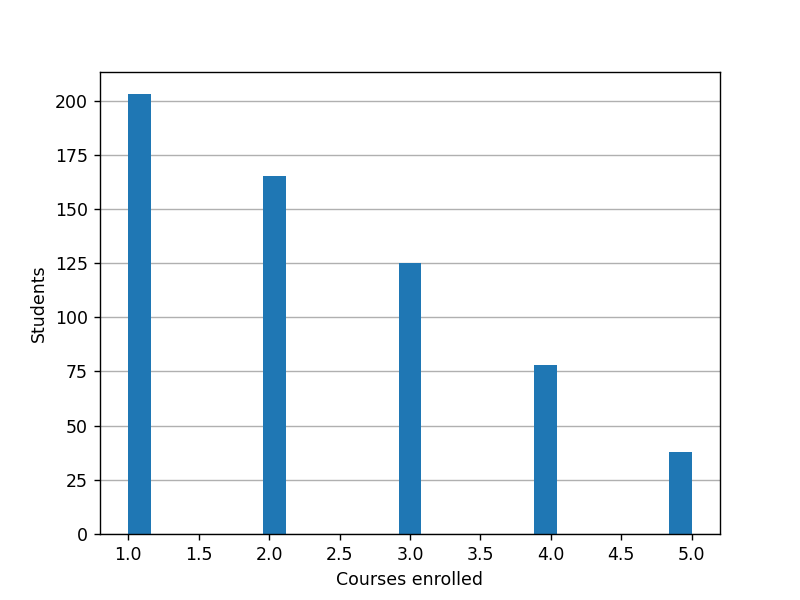

In [9]:
plt.hist(df_students['#courses'], bins=25,  zorder=2)
plt.grid(axis='y', zorder=0)
plt.ylabel('Students')
plt.xlabel('Courses enrolled')
plt.show()